# Transfer learning - feature extraction

Leveraging an already pre-trained model to adapt to a specific problem. It also often providers greater results with less data compared to a regular model with more data

Ex: Using models trained on ImageNet

There are different types of transfer learning:
* **As is** - use a pretrained model as it is to the current problem
 * Helpful if the current problem has the same number of classes as data it was trained on (Ex: ImageNet), however, not as helpful if they're different.
 * On tensorflow Hub models with `/classification` provide this
 
* **Feature extraction** - take the underlying patterns (weights) and adjust its outputs to better suit the current problem.
 * Current problem has different number of classes than original data, therefore the underlying patterns learnt can be leveraged and only the output layer could be changed with the current problem's number of classes & train.
 * It's important to not to train the entire network again by Freezing majority of the layers and only train few of the top layers if necessary
 * On tensorflow Hub models with `/feature-vector` provide this
* **Fine Tuning** - training some, many, or all of the layers as to Fine-tune the model to the current problem
 * Have 100+ classes and data is slighly different to the original trained data
 
A common workflow is to freeze the bottom layers and train the top 2-3 layers of the model, and gradually unfreeze lower layers to further fine-tune it.

**Note** Why only the top 2-3 layers?
> lower the layer the larger features it learns. (Ex: lower layers learn outline of legs, but topper layers learn shape of teeth). Often, the larger features are kept the same since they can be similar for both the data (original trained on & new to be trained on), whereas the fine-grained features would be more data-specific

<img src='https://camo.githubusercontent.com/fe18c60e0d7acad76998ae1ca52f3e45f263c79a916c2d7a4308b42b456d9038/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30342d646966666572656e742d6b696e64732d6f662d7472616e736665722d6c6561726e696e672e706e67' />

**Continuation of the CNN notebook**

### Data Exploration

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!curl -O https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  160M    0   304    0     0    382      0   5d 02h --:--:--   5d 02h   381
  0  160M    0  977k    0     0   614k      0  0:04:27  0:00:01  0:04:26  614k
  1  160M    1 2238k    0     0   824k      0  0:03:19  0:00:02  0:03:17  824k
  2  160M    2 3358k    0     0   935k      0  0:02:55  0:00:03  0:02:52  935k
  2  160M    2 4734k    0     0  1032k      0  0:02:39  0:00:04  0:02:35 1032k
  3  160M    3 5566k    0     0   997k      0  0:02:45  0:00:05  0:02:40 1163k
  4  160M    4 6670k    0     0  1013k      0  0:02:42  0:00:06  0:02:36 1140k
  4  160M    4 8030k    0     0  1059k      0  0:02:35  0:00:07  0:02:28 1190k
  5  160M    5 9038k    0     0  1052k      0  0:02:36  0:00:08  0:02:28 1135k
  6  160M    6 10.2M    0     0  1097k      0  0:02

In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('data/10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in \'{dirpath}\'.')

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [7]:
# Create data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Callbacks

Extra functionality that are added to models that run before or after training
* EarlyStopping - stop model training if a specified metric hasn't changed for a step number of epochs
* TensorBoard - monitor training process
* ModelCheckpoint - create model save checkpoints

In [22]:
# Create tensorboard callback - each model needs its own callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f'{dir_name}/{experiment_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

### Creating models using TensorFlow hub

Using tensorflow hub best perfoming models can be narrowed down by specifying the required use case, alongside https://paperswithcode.com/.

In this case one of the two best options are:
* ResNetV2
* EfficientNet

These models are State-of-the-art (SOTA): they achieved the lowest error rate on ImageNet at some point in time.

In [17]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
# Create a function to create a model from tensorflow hub
def create_model(model_url, num_classes=10):
    # Download pretrained model and save into a Keras layer
    feature_extraction_layer = hub.KerasLayer(
        model_url,
        # Freeze base layers (no need to retrain underlying patterns)
        trainable=False,
        name='feature_extraction_layer',
        input_shape=IMG_SHAPE + (3,)
    )
    
    model = tf.keras.Sequential([
        # Add feature extraction layer as base
        feature_extraction_layer,
        layers.Dense(num_classes, activation='linear', name='output_layer')
    ])
    
    return model

In [14]:
train_data.num_classes

10

In [18]:
# Create resnet50 feature extractor model
resnet_model = create_model(
    resnet_url,
    num_classes=train_data.num_classes
)

resnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [19]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


*all 23,564,800 parameters are nontrainable due to the layers being frozen*

What the above resnet model looks like

<img src='https://camo.githubusercontent.com/85694b6f1b9cd4df5dd8cc256d9902f40b00b0dbe16f045872510d4205c2d735/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30342d7265736e65742d666561747572652d657874726163746f722e706e67' />

In [23]:
resnet_history = resnet_model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name='tensorboard_logs', experiment_name='resnet50V2')]
)

Saving TensorBoard log files to: tensorboard_logs/resnet50V2/20220923-145132
Epoch 1/5
24/24 [==============================] - 261s 11s/step - loss: 1.9648 - accuracy: 0.3613 - val_loss: 1.2077 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 250s 11s/step - loss: 0.9028 - accuracy: 0.7373 - val_loss: 0.8941 - val_accuracy: 0.7164
Epoch 3/5
24/24 [==============================] - 248s 11s/step - loss: 0.6230 - accuracy: 0.8213 - val_loss: 0.7575 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 258s 11s/step - loss: 0.4804 - accuracy: 0.8720 - val_loss: 0.7188 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 276s 12s/step - loss: 0.3780 - accuracy: 0.9107 - val_loss: 0.6778 - val_accuracy: 0.7828


The power of Transfer Learning is quite apparent

In [32]:
# Plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Start from zero
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

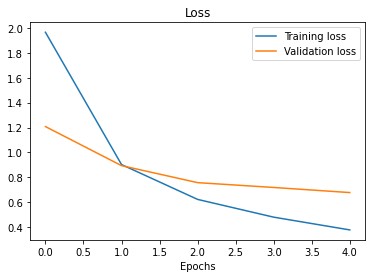

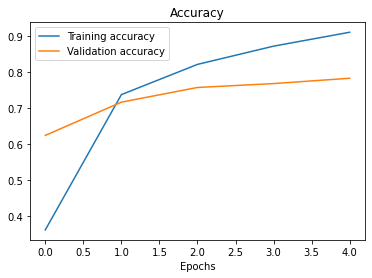

In [33]:
plot_loss_curves(resnet_history)

In [34]:
# Create Efficientnet feature extraction model
efficientnet_model = create_model(
    efficientnet_url,
    train_data.num_classes
)

efficientnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

efficientnet_history = efficientnet_model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name='tensorboard_logs', experiment_name='efficientnetB0')]
)

Saving TensorBoard log files to: tensorboard_logs/efficientnetB0/20220923-152313
Epoch 1/5
24/24 [==============================] - 143s 6s/step - loss: 1.9436 - accuracy: 0.3467 - val_loss: 1.5080 - val_accuracy: 0.6112
Epoch 2/5
24/24 [==============================] - 119s 5s/step - loss: 1.2947 - accuracy: 0.6867 - val_loss: 1.1238 - val_accuracy: 0.7176
Epoch 3/5
24/24 [==============================] - 117s 5s/step - loss: 0.9978 - accuracy: 0.7520 - val_loss: 0.9508 - val_accuracy: 0.7420
Epoch 4/5
24/24 [==============================] - 120s 5s/step - loss: 0.8385 - accuracy: 0.7973 - val_loss: 0.8578 - val_accuracy: 0.7572
Epoch 5/5
24/24 [==============================] - 114s 5s/step - loss: 0.7265 - accuracy: 0.8227 - val_loss: 0.7988 - val_accuracy: 0.7716


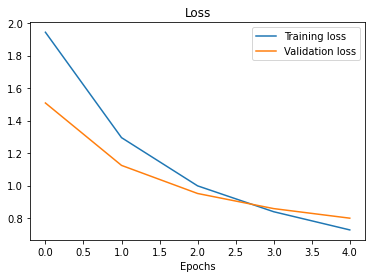

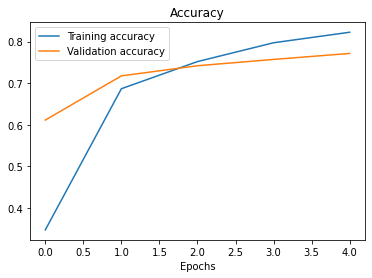

In [36]:
plot_loss_curves(efficientnet_history)

In [37]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


### Comparing performance using Tensorboard

A way to visually explore models performance & internals

In [39]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_logs